In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
a, b = [2, 3]

In [5]:
from scipy.stats import norm

# Markov chains

$$ P(x_{t+1}) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{(x_{t+1} - 0.5 x_t)^2}{2} \right) $$

In [6]:
x = [100]
y = [-27]

In [7]:
iterations = 100
i = 0

while i < iterations:
    x_next = norm.rvs(loc=0.5*x[-1], scale=1)
    y_next = norm.rvs(loc=0.5*y[-1], scale=1)
    
    x.append(x_next)
    y.append(y_next)
    i = i + 1

<IPython.core.display.Javascript object>


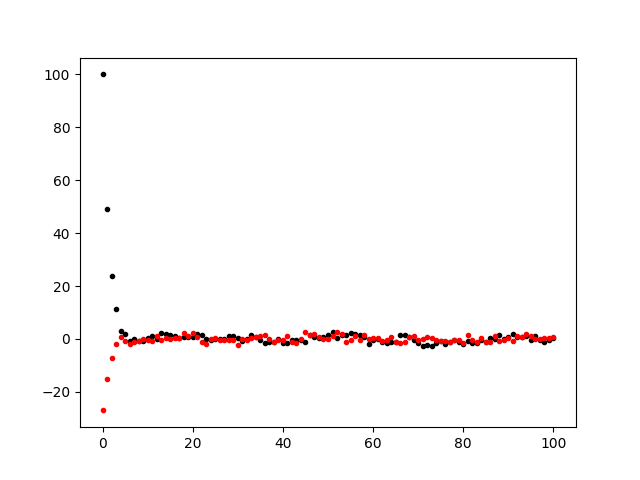

In [8]:
plt.figure()
plt.plot(x, 'k.')
plt.plot(y, 'r.')

In [60]:
np.std(x[50:])

1.2587291132882912

# Metropolis algorithm

In [42]:
from scipy.stats import beta, binom, truncnorm, uniform

In [10]:
theta = np.linspace(0, 1, num=1000)
likelihood = binom.pmf(61, 100, theta)
prior = beta.pdf(theta, 5, 17)
posterior = prior * likelihood

<IPython.core.display.Javascript object>


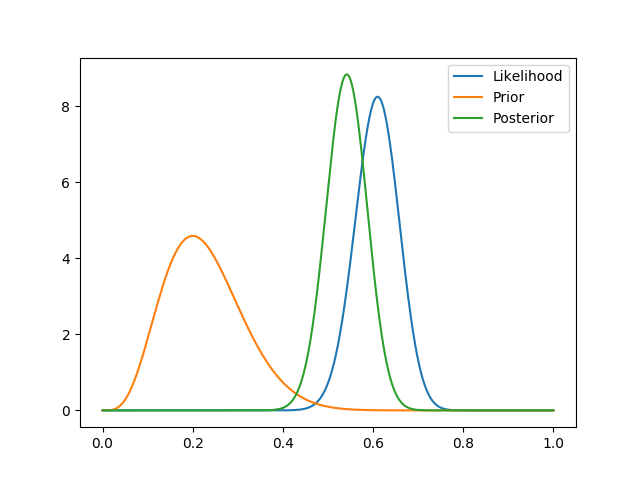

In [11]:
plt.figure()
plt.plot(theta, likelihood/(likelihood.sum()/1000), label='Likelihood')
plt.plot(theta, prior/(prior.sum()/1000), label='Prior')
plt.plot(theta, posterior/(posterior.sum()/1000), label='Posterior')
plt.legend()

In [2]:
import numpy as np
[1,2,3] + np.random.normal(2,2,size=3)

array([ 1.4256436 , -0.21753556,  5.26823949])

In [12]:
from scipy.interpolate import interp1d

In [15]:
P = interp1d(theta, likelihood*prior)

In [16]:
def metropolis(start, n_iterations):
    x = [start]
    i = 0

    while i < n_iterations:
        # Proposal distribution: theta_p = theta_current + N(0, 0.3)
        theta_p = x[-1] + norm.rvs(loc=0, scale=0.3)
        if theta_p > 1:
            theta_p = 1
        elif theta_p < 0:
            theta_p = 0

        # Calculate r = acceptance ratio = P(theta_p) / P(theta_current)
        # P(x) = prior * likelihood
        #P = interp1d(theta, likelihood*prior)
        r = P(theta_p) / P(x[-1])

        if r >= 1:
            x.append(theta_p)
        elif r < 1:
            u = np.random.uniform(0, 1)
            if u < r:
                x.append(theta_p)
            else:
                x.append(x[-1])
        i = i + 1
    
    return x

In [23]:
x = metropolis(0.5, 2000000)

<IPython.core.display.Javascript object>


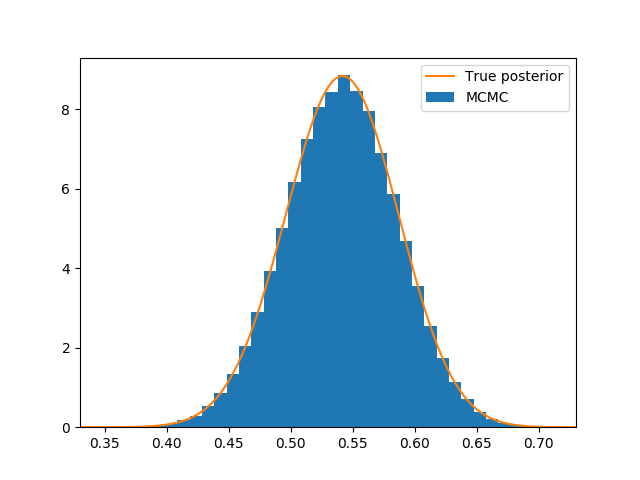

In [41]:
plt.figure()
plt.hist(x, density=True, bins=45, label='MCMC')
plt.plot(theta, posterior/(posterior.sum()/len(posterior)), label='True posterior')
plt.xlim(0.33, 0.73)
plt.legend()

# 2d Metropolis algorithm

In [88]:
theta1 = np.linspace(0, 1, num=100)
theta2 = np.linspace(61, 150, num=100)
likelihood = np.array([np.array([binom.pmf(61, th2, th1) for th1 in theta1]) for th2 in theta2])
prior1 = uniform.pdf(theta1, loc=0, scale=1)#beta.pdf(theta1, 5, 17)
prior2 = uniform.pdf(theta2, loc=61, scale=150-61)
prior = np.array([np.array([prior1[i]*prior2[j] for i in range(100)]) for j in range(100)])

<IPython.core.display.Javascript object>


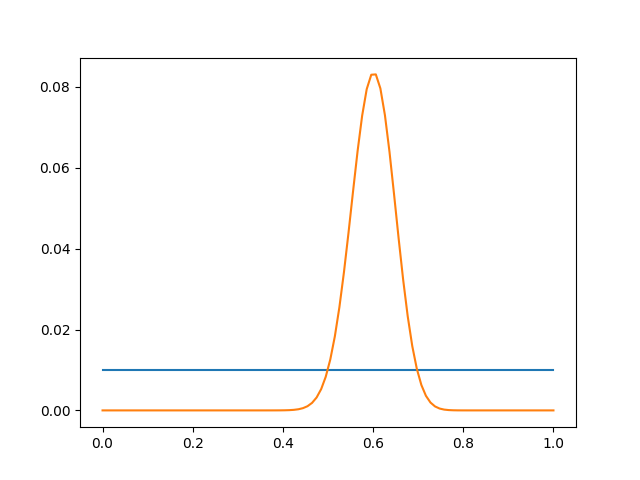

In [89]:
plt.figure()
plt.plot(theta1, prior[45]/prior[45].sum())
plt.plot(theta1, likelihood[45]/likelihood[45].sum())

In [90]:
from scipy.interpolate import interp2d

In [120]:
P = interp2d(theta1, theta2, likelihood*prior)

In [306]:
def metropolis2d(start, n_iterations):
    x = [start]
    i = 0

    while i < n_iterations:
        # Proposal distribution: theta_p = theta_current + N(0, 0.3)
        theta1_p = x[-1][0] + norm.rvs(loc=0, scale=0.3)
        theta2_p = x[-1][1] + norm.rvs(loc=0, scale=30)
        if theta1_p > 1:
            i = i + 1
            continue
        elif theta1_p < 0:
            i = i + 1
            continue
        elif theta2_p > 150:
            i = i + 1
            continue
        elif theta2_p < 61:
            i = i + 1
            continue
        else:
            r = P(theta1_p, theta2_p) / P(x[-1][0], x[-1][1])
        # Calculate r = acceptance ratio = P(theta_p) / P(theta_current)
        # P(x) = prior * likelihood
        #P = interp1d(theta, likelihood*prior)


        if r >= 1:
            x.append((theta1_p, theta2_p))
        elif r < 1:
            u = np.random.uniform(0, 1)
            if u < r:
                x.append((theta1_p, theta2_p))
            else:
                i = i + 1
                continue#x.append(x[-1])
        i = i + 1
    
    return x

In [307]:
y = metropolis2d((0.5, 65), 500000)

<IPython.core.display.Javascript object>


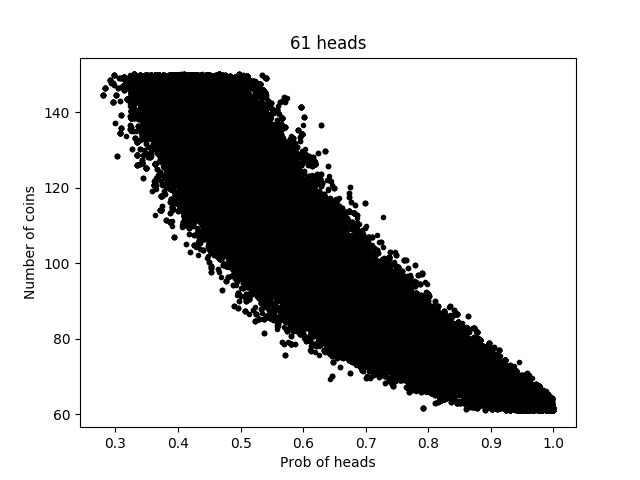

Text(0.5,1,'61 heads')

In [303]:
plt.figure()
plt.plot(np.array([point[0] for point in y[100000:]]), np.array([point[1] for point in y[100000:]]), 'k.')
plt.xlabel('Prob of heads')
plt.ylabel('Number of coins')
plt.title('61 heads')

<IPython.core.display.Javascript object>


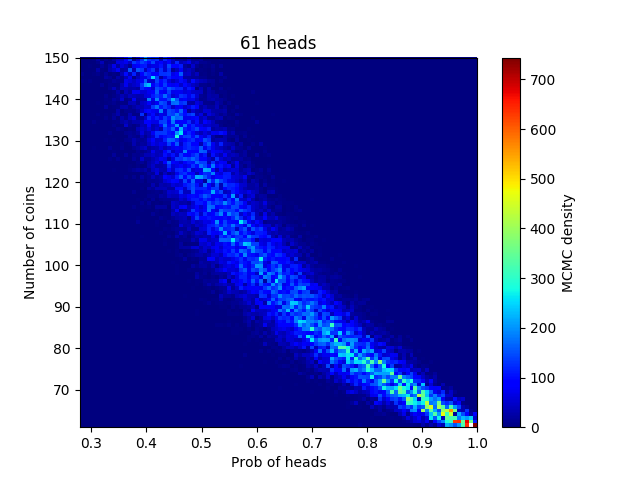

Text(0.5,1,'61 heads')

In [289]:
plt.figure()
plt.hist2d(
    np.array([point[0] for point in y[250000:]]), 
    np.array([point[1] for point in y[250000:]]), 
    bins=100, cmap='jet', cmax=1000
)
plt.colorbar(label='MCMC density')
plt.xlabel('Prob of heads')
plt.ylabel('Number of coins')
plt.title('61 heads')

<IPython.core.display.Javascript object>


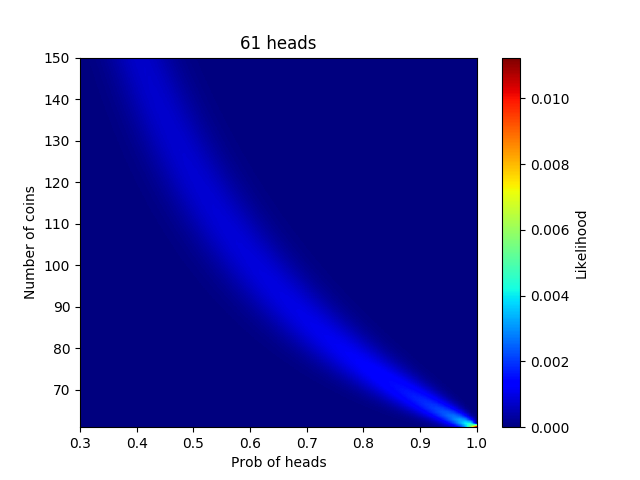

Text(0.5,1,'61 heads')

In [290]:
plt.figure()
plt.imshow(P(np.linspace(0.3, 1, num=1000), np.linspace(61, 150, num=1000)), extent=[0.3,1,61, 150], aspect='auto', origin='lower', cmap='jet')
plt.colorbar(label='Likelihood')
plt.xlabel('Prob of heads')
plt.ylabel('Number of coins')
plt.title('61 heads')

<IPython.core.display.Javascript object>


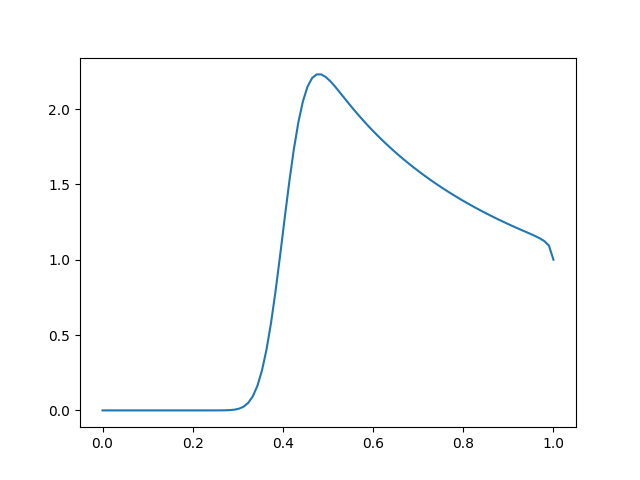

In [291]:
plt.figure()
plt.plot(theta1,np.sum(likelihood, axis=0))

<IPython.core.display.Javascript object>


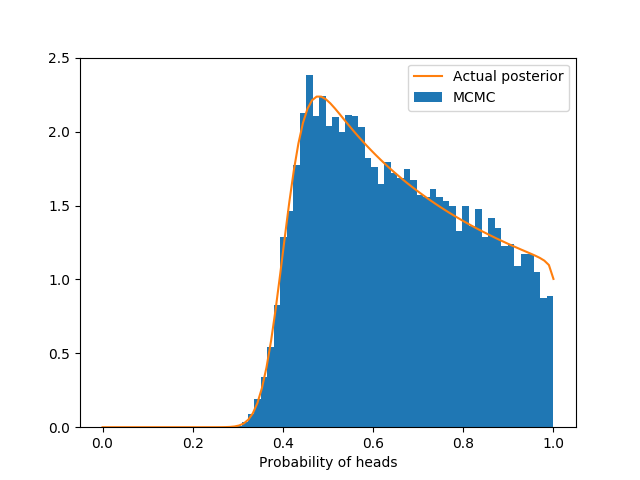

In [297]:
plt.figure()
plt.hist(np.array([point[0] for point in y[150000:]]), density=True, bins=50, label='MCMC')
plt.plot(theta1,np.sum(likelihood, axis=0)/(np.sum(likelihood, axis=0).sum()/len(np.sum(likelihood, axis=0))), label='Actual posterior')
plt.xlabel('Probability of heads')
plt.legend()

<IPython.core.display.Javascript object>


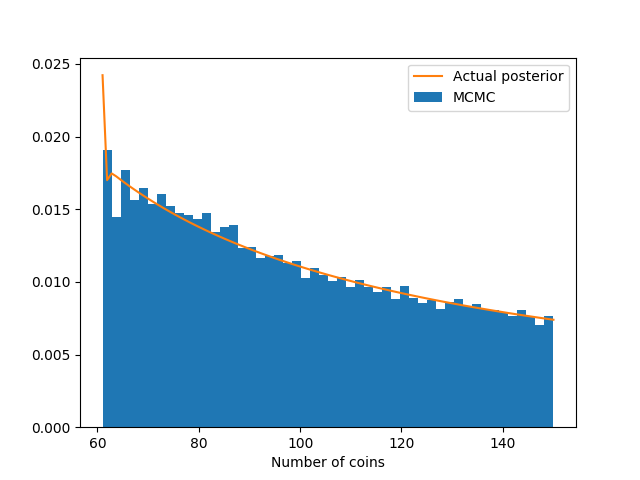

In [298]:
plt.figure()
plt.hist(np.array([point[1] for point in y[150000:]]), density=True, bins=50, label='MCMC')
plt.plot(theta2,np.sum(likelihood, axis=1)/(np.sum(likelihood, axis=1).sum()/len(np.sum(likelihood, axis=1)))/89, label='Actual posterior')
plt.xlabel('Number of coins')
plt.legend()

<IPython.core.display.Javascript object>


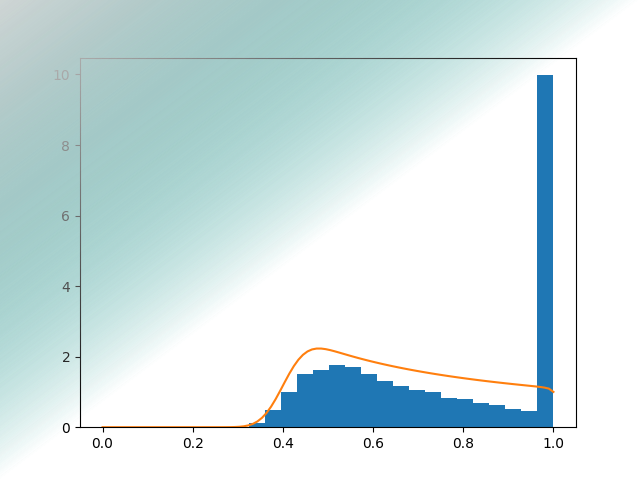

In [178]:
plt.figure()
plt.hist(np.array([point[0] for point in y[100000:] if point[0] < 1.1]), density=True, bins=20)
plt.plot(theta1,np.sum(likelihood, axis=0))

In [154]:
L = np.loadtxt('L-L1_LOSC_4_V2-1126259446-32.txt')

<IPython.core.display.Javascript object>


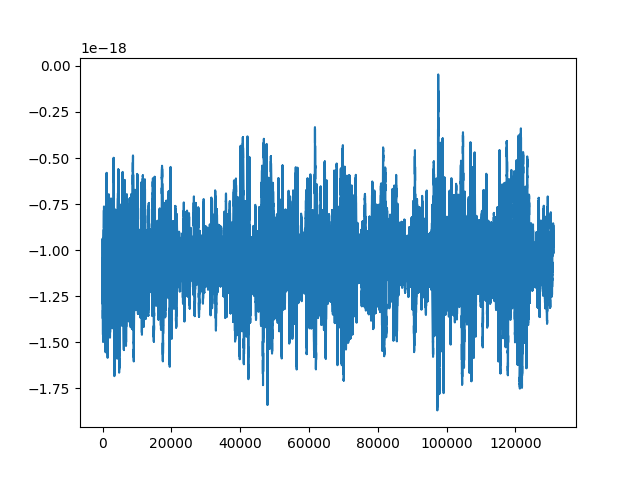

In [155]:
plt.figure()
plt.plot(L)

In [158]:
from matplotlib import mlab

In [165]:
fs = 4096
dt = 1/4096.0
NFFT = 4 * fs
Pxx_L1, freqs = mlab.psd(L, Fs = fs, NFFT = NFFT)
psd_L1 = interp1d(freqs, Pxx_L1)

In [166]:
Nt = len(L)
freqs = np.fft.rfftfreq(Nt, dt)
freqs1 = np.linspace(0,2048.,Nt/2+1)

# whitening: transform to freq domain, divide by asd, then transform back, 
# taking care to get normalization right.
hf = np.fft.rfft(L)
norm = 1./np.sqrt(1./(dt*2))
white_hf = hf / np.sqrt(psd_L1(freqs)) * norm
white_ht = np.fft.irfft(white_hf, n=Nt)

<IPython.core.display.Javascript object>


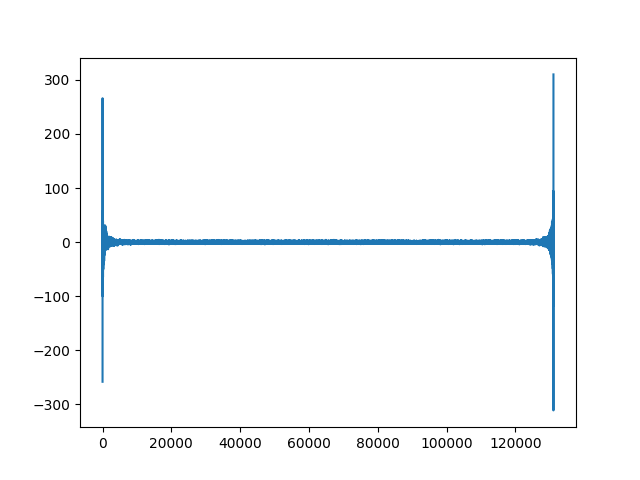

In [167]:
plt.figure()
plt.plot(white_ht)

In [168]:
from scipy.signal import filtfilt, butter

In [170]:
bb, ab = butter(4, [35*2./fs, 350*2./fs], btype='band')
normalization = np.sqrt((350.0-35.0)/(fs/2))
strain_L1_whitenbp = filtfilt(bb, ab, white_ht) / normalization

<IPython.core.display.Javascript object>


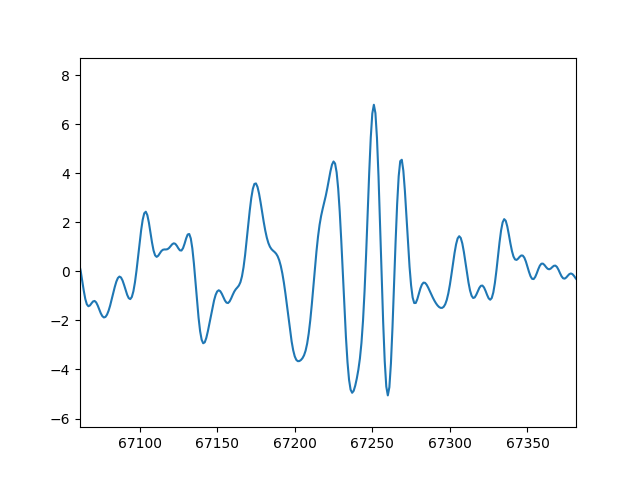

In [171]:
plt.figure()
plt.plot(strain_L1_whitenbp)

In [172]:
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [178]:
pycbc_strain = read_frame('L-L1_LOSC_4_V2-1126257414-4096.gwf', 'L1:LOSC-STRAIN')

RuntimeError: RETURN: untrapped XLAL error

In [179]:
from pycbc.types import TimeSeries

In [181]:
strain_4096 = np.loadtxt('L-L1_LOSC_4_V2-1126257414-4096.txt')

In [182]:
strain2 = TimeSeries(strain_4096, delta_t=1/4096.0)

In [183]:
stilde2 = strain2.to_frequencyseries()

In [184]:
psds =  interpolate(strain2.psd(16), stilde2.delta_f)

In [185]:
psds = inverse_spectrum_truncation(psds, 16*strain2.sample_rate, low_frequency_cutoff=15.0, trunc_method='hann')

In [186]:
whitened_strain = stilde2 / psds**0.5

In [187]:
whitened_strain = whitened_strain.to_timeseries()

In [ ]:
pycbc_strain_bp = filtfilt(b, a)